In this notebook I use techniques like EDA, feature engineering, and feature selection to handle a dataset with many features. I then build a model using the SVM algorithm to predict which bank customers will churn and which will not with the goal of helping banks reduce customer loss and improve retention strategies 
The dataset used is available at the following link:

[link](https://www.kaggle.com/datasets/gauravtopre/bank-customer-churn-dataset)

#  1)dataset

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier

path = "/kaggle/input/bank-customer-churn-dataset/Bank Customer Churn Prediction.csv"
df = pd.read_csv(path)

df.head()


,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


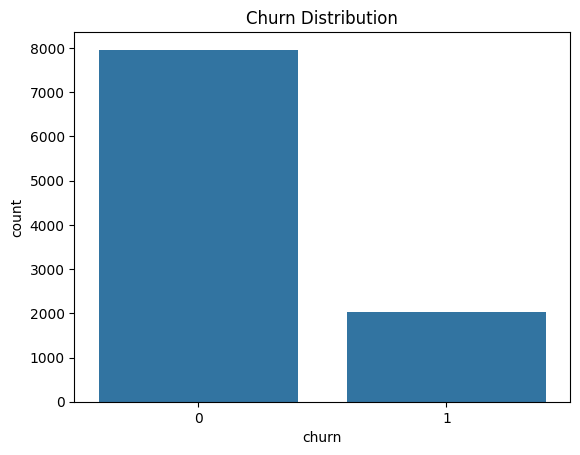

In [2]:
df["churn"].value_counts(normalize=True) * 100
sns.countplot(x="churn", data=df)
plt.title("Churn Distribution")
plt.show()


#  2) applying EDA

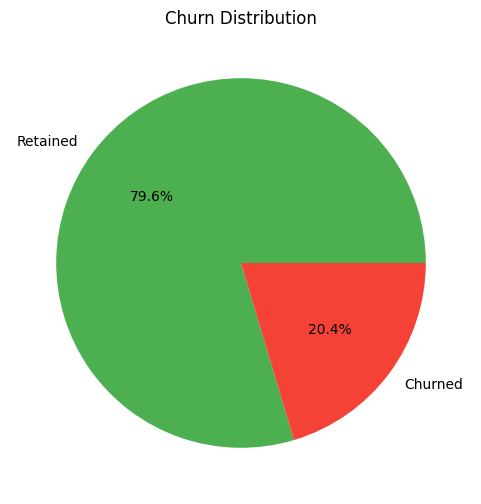

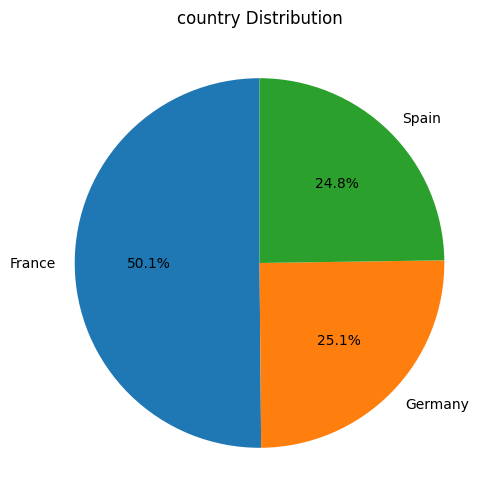

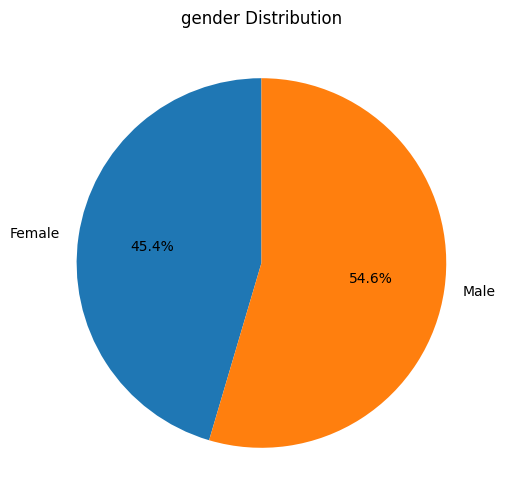

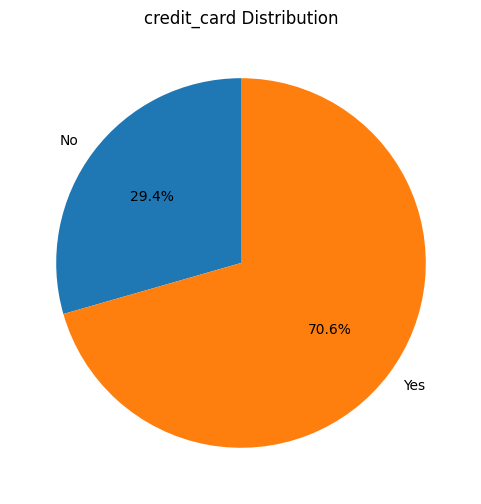

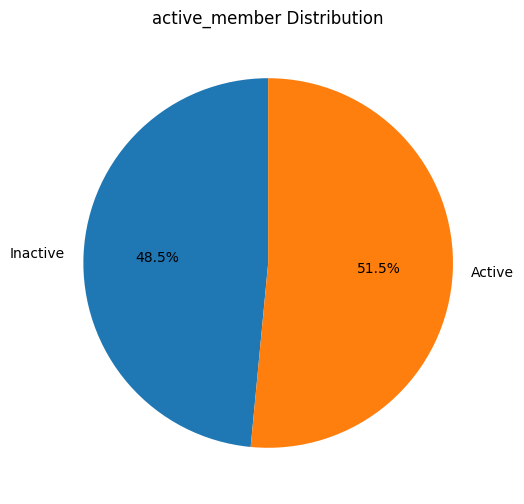

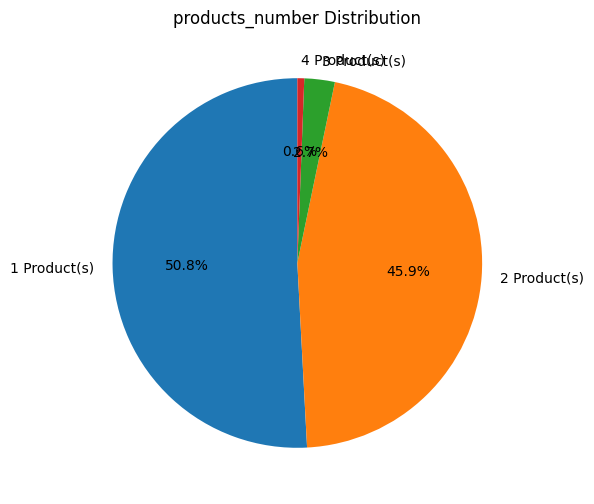


Feature: country
  France: Retained = 4204 (52.8%), Churned = 810 (39.8%)
  Germany: Retained = 1695 (21.3%), Churned = 814 (40.0%)
  Spain: Retained = 2064 (25.9%), Churned = 413 (20.3%)

Feature: gender
  Female: Retained = 3404 (42.7%), Churned = 1139 (55.9%)
  Male: Retained = 4559 (57.3%), Churned = 898 (44.1%)

Feature: credit_card
  0: Retained = 2332 (29.3%), Churned = 613 (30.1%)
  1: Retained = 5631 (70.7%), Churned = 1424 (69.9%)

Feature: active_member
  0: Retained = 3547 (44.5%), Churned = 1302 (63.9%)
  1: Retained = 4416 (55.5%), Churned = 735 (36.1%)

Feature: products_number
  1: Retained = 3675 (46.2%), Churned = 1409 (69.2%)
  2: Retained = 4242 (53.3%), Churned = 348 (17.1%)
  3: Retained = 46 (0.6%), Churned = 220 (10.8%)
  4: Retained = 0 (0.0%), Churned = 60 (2.9%)

Feature: credit_score
  Retained (mean ± std): 651.85 ± 95.65
  Churned  (mean ± std): 645.35 ± 100.32
  Difference in mean: -6.50

Feature: age
  Retained (mean ± std): 37.41 ± 10.13
  Churned  (me

In [45]:
churn_counts = df['churn'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(churn_counts, labels=['Retained','Churned'], autopct='%1.1f%%', colors=['#4CAF50','#F44336'])
plt.title('Churn Distribution')
plt.show()


categorical_features = ['country', 'gender', 'credit_card', 'active_member', 'products_number']

for col in categorical_features:
    counts = df[col].value_counts().sort_index()
    plt.figure(figsize=(6,6))
    labels = [str(i) for i in counts.index]
    if col == 'credit_card':
        labels = ['No', 'Yes']
    if col == 'active_member':
        labels = ['Inactive','Active']
    if col == 'products_number':
        labels = [f'{i} Product(s)' for i in counts.index]
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90)
    plt.title(f'{col} Distribution')
    plt.show()

for col in categorical_features:
    print(f"\nFeature: {col}")
    categories = df[col].unique()
    for cat in sorted(categories):
        retained_count = len(df[(df[col]==cat) & (df['churn']==0)])
        churned_count  = len(df[(df[col]==cat) & (df['churn']==1)])
        total_retained = len(df[df['churn']==0])
        total_churned  = len(df[df['churn']==1])
        retained_pct = retained_count / total_retained * 100
        churned_pct  = churned_count / total_churned * 100
        print(f"  {cat}: Retained = {retained_count} ({retained_pct:.1f}%), Churned = {churned_count} ({churned_pct:.1f}%)")

numerical_features = ['credit_score', 'age', 'tenure', 'balance', 'estimated_salary']

for col in numerical_features:
    churned = df[df['churn']==1][col]
    retained = df[df['churn']==0][col]
    print(f"\nFeature: {col}")
    print(f"  Retained (mean ± std): {retained.mean():.2f} ± {retained.std():.2f}")
    print(f"  Churned  (mean ± std): {churned.mean():.2f} ± {churned.std():.2f}")
    print(f"  Difference in mean: {churned.mean() - retained.mean():.2f}")



# 3)  FEATURE ENGINEERING

In [6]:

y = df["churn"]
X = df.drop(columns=["churn"])
X["balance_salary_ratio"] = X["balance"] / (X["estimated_salary"] + 1)

X["tenure_per_age"] = X["tenure"] / (X["age"] + 1)

X["multiple_products"] = (X["products_number"] > 1).astype(int)



# 4) DATA PREPARATION FOR MODELING

In [16]:


num_features = [
    "credit_score", "age", "tenure", "balance", "estimated_salary",
    "balance_salary_ratio", "tenure_per_age"
]

cat_features = ["country", "gender", "products_number"]

bin_features = ["credit_card", "active_member", "multiple_products"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_features),
        ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), cat_features),
        ("bin", "passthrough", bin_features)
    ]
)



#  5)selection important features

In [10]:
from xgboost import XGBClassifier
import pandas as pd

xgb = XGBClassifier(
    n_estimators=300,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="binary:logistic",
    eval_metric="logloss",
    random_state=42
)

xgb.fit(X_train_p, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

Selected features using XGBoost:
cat__products_number_2       0.223200
bin__multiple_products       0.167717
num__age                     0.111883
bin__active_member           0.108359
cat__products_number_3       0.073470
cat__country_Germany         0.071509
cat__gender_Male             0.035202
num__balance                 0.034677
cat__products_number_4       0.031776
num__balance_salary_ratio    0.028158
cat__country_Spain           0.023211
num__estimated_salary        0.020155
dtype: float32


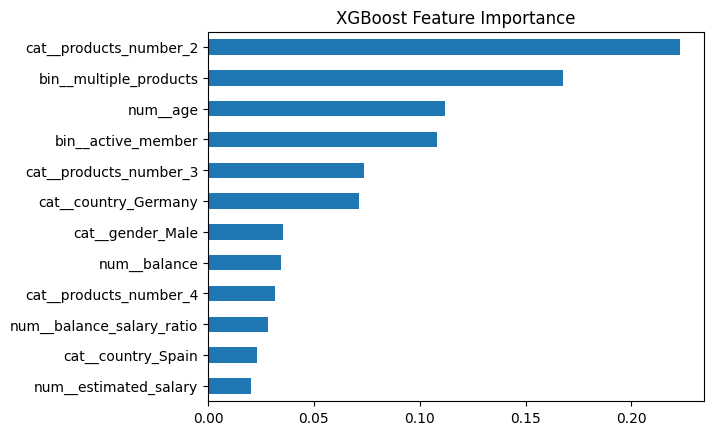

In [14]:
selected_features = importances[importances >= 0.02]

print("Selected features using XGBoost:")
print(selected_features)
import matplotlib.pyplot as plt

selected_features.sort_values().plot(kind="barh")
plt.title("XGBoost Feature Importance")
plt.show()


# 6) Building the  MODEL  using SVM 

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps=[
    ("preprocessing", preprocessor),
    ("svm", SVC(
        kernel="rbf",
        C=1.0,
        gamma="scale",
        class_weight="balanced",
        random_state=42
    ))
])


In [30]:
from sklearn.model_selection import StratifiedKFold, cross_validate

cv = StratifiedKFold(
    n_splits=5,
    shuffle=True,
    random_state=42
)

scoring = {
    "roc_auc": "roc_auc",
}

cv_results = cross_validate(
    svm_pipeline,
    X,
    y,
    cv=cv,
    scoring=scoring,
    n_jobs=-1
)


#  7)Evaluated the model

In [27]:

print("ROC-AUC :", cv_results["test_roc_auc"].mean())


ROC-AUC : 0.8533613526197958


Confusion Matrix:
[[6425 1538]
 [ 514 1523]]


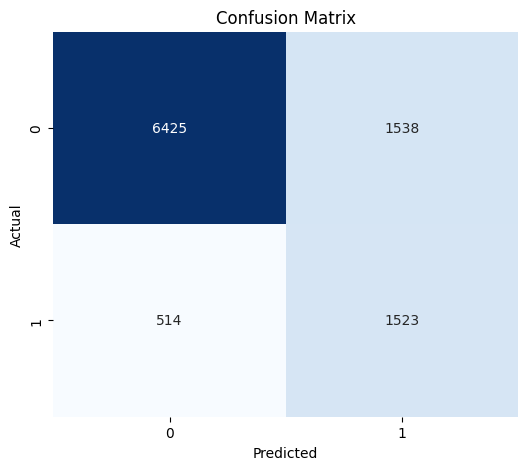

In [43]:


y_pred_cv = cross_val_predict(
    svm_pipeline,
    X,
    y,
    cv=cv,
    n_jobs=-1
)

cm = confusion_matrix(y, y_pred_cv)
print("Confusion Matrix:")
print(cm)

# Plot confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()
